In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
from scipy.optimize import curve_fit

%matplotlib inline

# Calibration du gyroscope

- Acquisition en position fixe
- Calibration par estimation et correction du biais résiduel

In [173]:
#file obtained by moving mpu9250 in infinity shape
df = pd.read_csv('../logs/calib_gyro.txt', header=None, sep='\t', error_bad_lines=False)  #sometimes record are lagging, creating splitted lines
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df.dropna(inplace=True)
df.columns = ['gx', 'gy', 'gz', 'gx_cal', 'gy_cal', 'gz_cal', 'T']

b'Skipping line 4: expected 7 fields, saw 9\nSkipping line 300: expected 7 fields, saw 9\nSkipping line 2629: expected 7 fields, saw 12\nSkipping line 3367: expected 7 fields, saw 12\nSkipping line 6379: expected 7 fields, saw 11\nSkipping line 7944: expected 7 fields, saw 12\nSkipping line 8900: expected 7 fields, saw 13\n'


In [174]:
df.describe()

,gx,gy,gz,gx_cal,gy_cal,gz_cal,T
count,14361.000000,14361.000000,14361.000000,14361.000000,14361.000000,14361.000000,14361.000000
mean,0.000230,-0.000273,0.000171,0.000259,-0.000217,-0.000042,30.774501
std,0.000529,0.000458,0.000474,0.000529,0.000458,0.000474,0.167319
min,-0.001812,-0.002063,-0.001487,-0.001783,-0.002007,-0.001700,30.506694
25%,-0.000081,-0.000598,-0.000156,-0.000052,-0.000542,-0.000369,30.626501
50%,0.000185,-0.000332,0.000111,0.000214,-0.000276,-0.000102,30.752300
75%,0.000585,0.000068,0.000510,0.000614,0.000124,0.000297,30.908048
max,0.002316,0.001400,0.001975,0.002345,0.001456,0.001762,31.198581


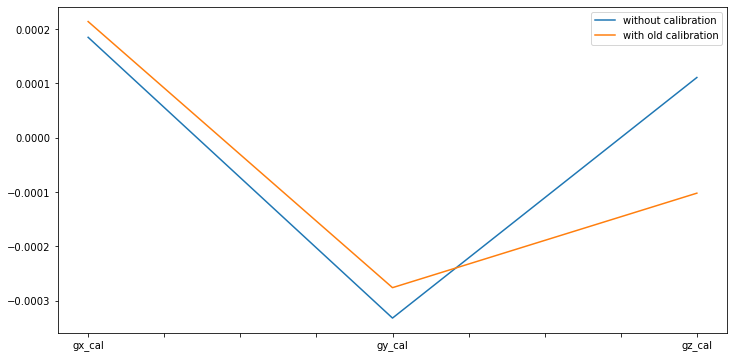

In [175]:
fig, ax = plt.subplots(1, 1, figsize=(12,6))
df[['gx', 'gy', 'gz']].median(axis=0).plot(ax=ax, label='without calibration')
df[['gx_cal', 'gy_cal', 'gz_cal']].median(axis=0).plot(ax=ax, label='with old calibration')
plt.legend()

<AxesSubplot:>

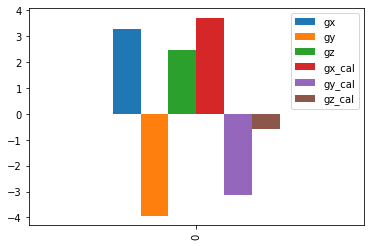

In [176]:
dico = {}
for col in df.columns:
    dico[col] = [np.trapz(df[col])]
del dico['T']
pd.DataFrame(dico).plot(kind='bar')

In [177]:
# Biais
dgX = df.gx.median()
dgY = df.gy.median()
dgZ = df.gz.median()

# Pénalisation
sigmaX = (df.gx**2).sum()
sigmaY = (df.gy**2).sum()
sigmaZ = (df.gz**2).sum()

In [178]:
print("""
  gx_cal = gx - {:.8f};
  gy_cal = gy - {:.8f};
  gz_cal = gz - {:.8f};
""".format(dgX, dgY, dgZ))  #Arduino code to c/c


  gx_cal = gx - 0.00018500;
  gy_cal = gy - -0.00033200;
  gz_cal = gz - 0.00011100;



<AxesSubplot:>

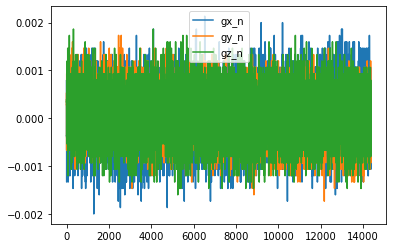

In [179]:
df.loc[:, 'gx_n'] = df.gx - dgX
df.loc[:, 'gy_n'] = df.gy - dgY
df.loc[:, 'gz_n'] = df.gz - dgZ
df[['gx_n', 'gy_n', 'gz_n']].plot()

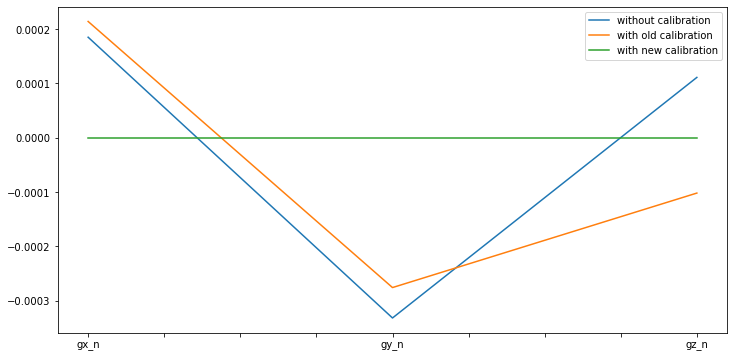

In [180]:
fig, ax = plt.subplots(1, 1, figsize=(12,6))
df[['gx', 'gy', 'gz']].median(axis=0).plot(ax=ax, label='without calibration')
df[['gx_cal', 'gy_cal', 'gz_cal']].median(axis=0).plot(ax=ax, label='with old calibration')
df[['gx_n', 'gy_n', 'gz_n']].median(axis=0).plot(ax=ax, label='with new calibration')
plt.legend()

In [181]:
# validation with new acquisition
df = pd.read_csv('../logs/calib_gyro_valid.txt', header=None, sep='\t', error_bad_lines=False) #sometimes record are lagging, creating splitted lines
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df.dropna(inplace=True)
df.columns = ['gx', 'gy', 'gz', 'gx_cal', 'gy_cal', 'gz_cal', 'T']

b'Skipping line 2568: expected 7 fields, saw 8\nSkipping line 2569: expected 7 fields, saw 10\nSkipping line 2622: expected 7 fields, saw 10\nSkipping line 3130: expected 7 fields, saw 8\nSkipping line 4715: expected 7 fields, saw 14\nSkipping line 4821: expected 7 fields, saw 8\nSkipping line 4954: expected 7 fields, saw 9\nSkipping line 5319: expected 7 fields, saw 9\nSkipping line 6830: expected 7 fields, saw 12\nSkipping line 9159: expected 7 fields, saw 11\n'


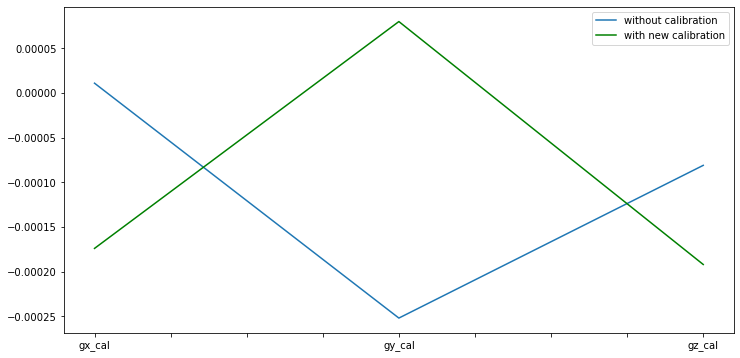

In [182]:
fig, ax = plt.subplots(1, 1, figsize=(12,6))
df[['gx', 'gy', 'gz']].median(axis=0).plot(ax=ax, label='without calibration')
df[['gx_cal', 'gy_cal', 'gz_cal']].median(axis=0).plot(ax=ax, color='green', label='with new calibration')
plt.legend()

<AxesSubplot:>

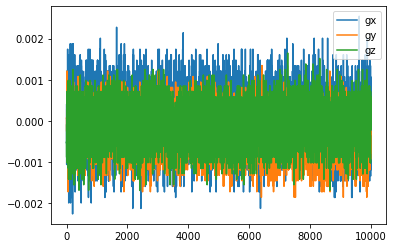

In [184]:
df[['gx', 'gy', 'gz']].iloc[:10000].plot()

<AxesSubplot:>

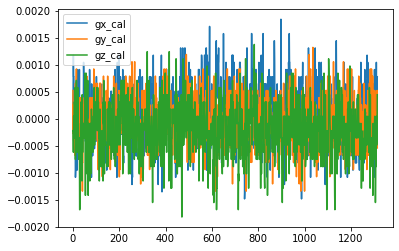

In [164]:
df[['gx_cal', 'gy_cal', 'gz_cal']].plot()

<AxesSubplot:>

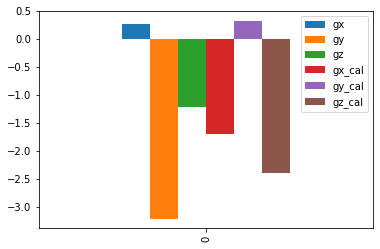

In [185]:
dico = {}
for col in df.columns:
    dico[col] = [np.trapz(df[col])]
del dico['T']
pd.DataFrame(dico).plot(kind='bar')

# to do : 
- nouvelle calibration du magno
- vérifier si la calibration gyro accel reste constante
- implémenter dans arduino les constantes si reste constant, sinon implémenter la calibration
- implémenter la double intégration de l'accéléro, la simple intégration du gyro, l'orientation du magnéto

https://github.com/nliaudat/magnetometer_calibration/blob/main/calibrate.py

# Calibration de l'accéléromètre

- Acquisition en position fixe
- Acquisition en position 1G, -1G, 0G, par axe

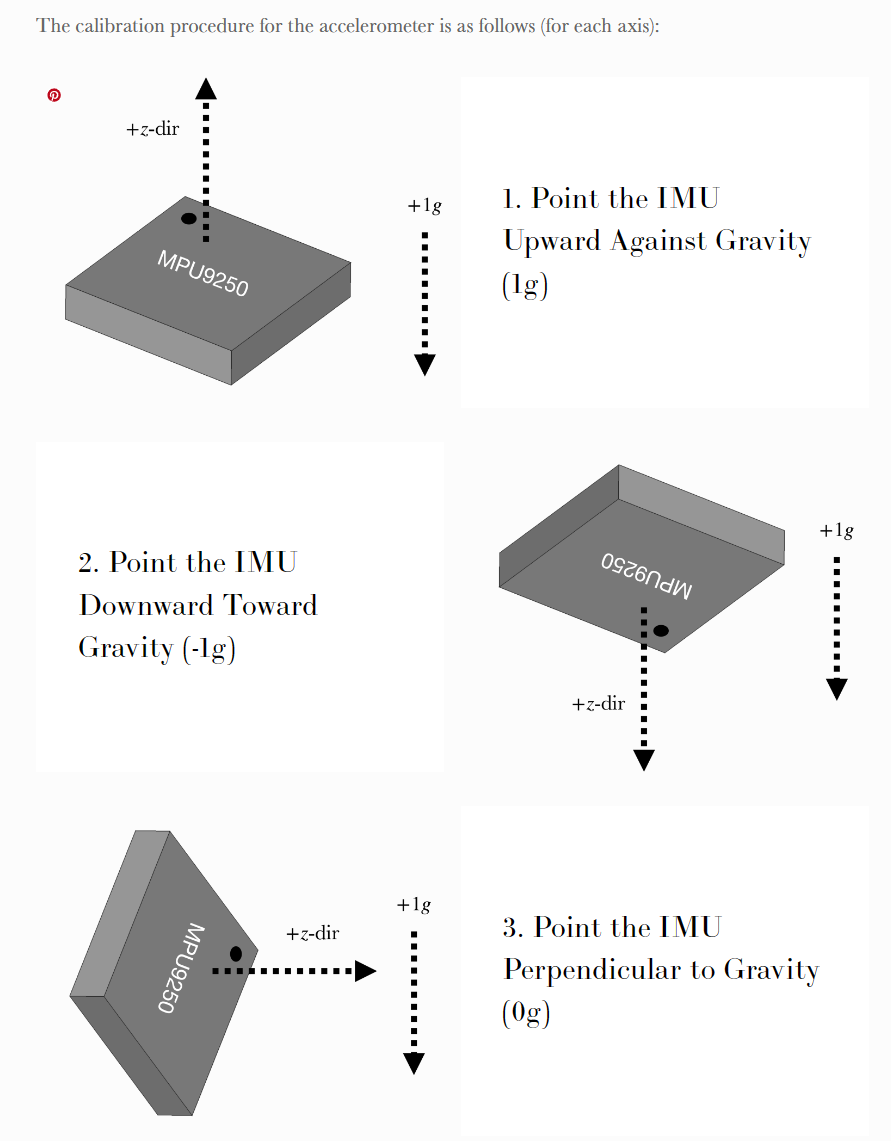

In [204]:
# validation with new acquisition
df = pd.read_csv('../logs/calib_accel_1st_step.txt', header=None, sep='\t', error_bad_lines=False) #sometimes record are lagging, creating splitted lines
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df.dropna(inplace=True)
df.columns = ['ax', 'ay', 'az', 'ax_cal', 'ay_cal', 'az_cal', 'T']

b'Skipping line 404: expected 7 fields, saw 12\n'


In [205]:
accel = df[['ax', 'ay', 'az']]

<AxesSubplot:>

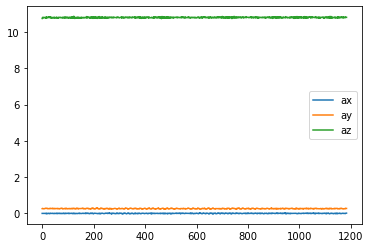

In [206]:
accel.plot()

In [207]:
norm

10.786323380554665

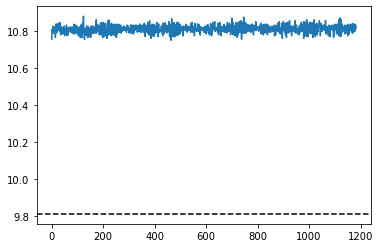

In [208]:
norm = accel.multiply(accel).sum(axis=1).apply(np.sqrt)
plt.plot(norm)
plt.axhline(9.81, color='k', linestyle='dashed')

In [209]:
norm = accel.multiply(accel).sum(axis=1).apply(np.sqrt).mean()

In [210]:
ref = np.array([0, 0, -norm])

In [211]:
def get_rotation_matrix(vec2, vec1=np.array([0, 0, -norm])):
    """get rotation matrix between two vectors using scipy"""
    vec1 = np.reshape(vec1, (1, -1))
    vec2 = np.reshape(vec2, (1, -1))
    r = R.align_vectors(vec2, vec1)
    return r[0].as_matrix()

In [212]:
def accel_fit(x_input,m_x,b):
    return (m_x*x_input)+b # fit equation for accel calibration

In [213]:
mat = get_rotation_matrix(vec1=accel.mean().values, vec2=ref)

<ipython-input-211-0bbd059c2387>:5: UserWarning: Optimal rotation is not uniquely or poorly defined for the given sets of vectors.
  r = R.align_vectors(vec2, vec1)


In [214]:
mat

array([[ 6.46455545e-17,  9.99722430e-01, -2.35597581e-02],
       [ 9.99999611e-01,  2.07866681e-05,  8.82050582e-04],
       [ 8.82295480e-04, -2.35597490e-02, -9.99722041e-01]])

In [215]:
normed_accel = pd.DataFrame(accel.apply(lambda d: np.dot(mat, d), axis=1).tolist())

https://makersportal.com/blog/calibration-of-an-inertial-measurement-unit-imu-with-raspberry-pi-part-ii

In [216]:
from scipy.optimize import curve_fit 


1 : sens gravité
2 : opposé gravité
3 : perpendiculaire gravité

par axe de l'IMU

x_G+
x_G-
x_0
y_G+
y_G-
y_0
z_G+
z_G-
z_0


b'Skipping line 9: expected 7 fields, saw 10\nSkipping line 272: expected 7 fields, saw 8\n'
b'Skipping line 334: expected 7 fields, saw 13\n'
b'Skipping line 12: expected 7 fields, saw 14\nSkipping line 1040: expected 7 fields, saw 8\nSkipping line 1042: expected 7 fields, saw 12\n'
b'Skipping line 334: expected 7 fields, saw 13\n'
b'Skipping line 404: expected 7 fields, saw 12\n'
b'Skipping line 12: expected 7 fields, saw 14\nSkipping line 1040: expected 7 fields, saw 8\nSkipping line 1042: expected 7 fields, saw 12\n'


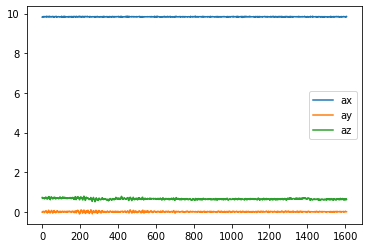

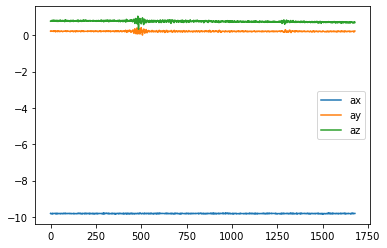

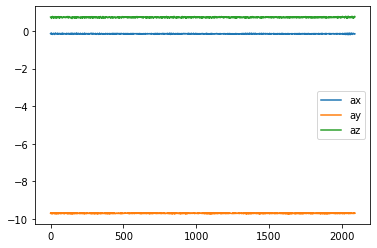

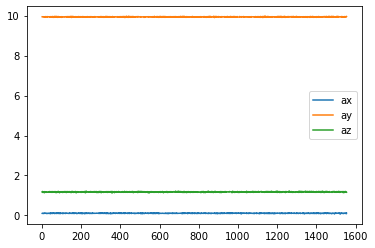

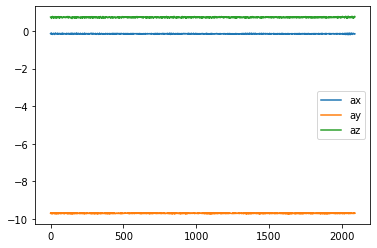

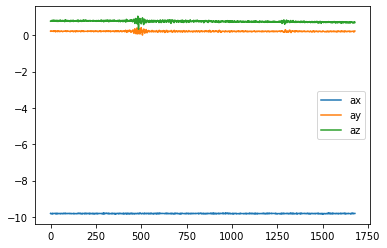

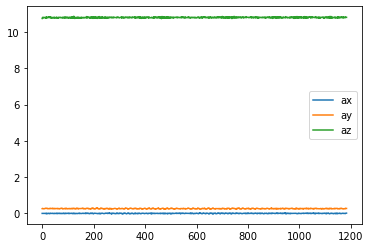

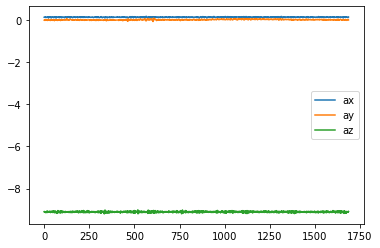

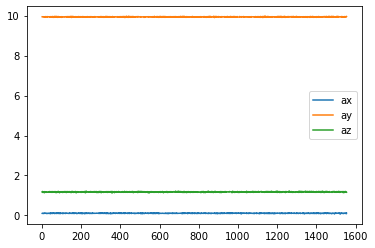

In [219]:
calibration_accel = []
for col in ['ax', 'ay', 'az']:
    values = []
    for name in ('G+', 'G-', '0'):
        print("{}_{}".format(col[-1], name))
        df = pd.read_csv('../logs/calib_accel_{}_{}.txt'.format(col[-1].upper(), name), header=None, sep='\t', error_bad_lines=False) #sometimes record are lagging, creating splitted lines
        for _col in df.columns:
            df[_col] = pd.to_numeric(df[_col], errors='coerce')
        df.dropna(inplace=True)
        df.columns = ['ax', 'ay', 'az', 'ax_cal', 'ay_cal', 'az_cal', 'T']
        df[['ax', 'ay', 'az']].plot()
        values.append(df[col].values)
    ref = [x*np.ones(y.shape) for x, y in zip([9.80665, -9.80665, 0],
                                          values)]
    popts,_ = curve_fit(accel_fit,np.hstack(values),
                           np.hstack(ref),
                            maxfev=10000)
    calibration_accel.append(popts)

In [224]:
print("""  ax_cal = {}*ax - {};
  ay_cal = {}*ay - {};
  az_cal = {}*az - {};""".format(*np.vstack(calibration_accel).ravel())) # Arduino code

  ax_cal = 0.9976785728444*ax - 0.05043063791143954;
  ay_cal = 0.9985945019697551*ay - -0.15370275713846238;
  az_cal = 0.9827670907542679*az - -0.951501639184257;


In [222]:
np.vstack(calibration_accel).ravel()

array([ 0.99767857,  0.05043064,  0.9985945 , -0.15370276,  0.98276709,
       -0.95150164])

In [47]:
df['axc'] = df.ax.apply(lambda d: accel_fit(d, *calibration_accel[0]))
df['ayc'] = df.ay.apply(lambda d: accel_fit(d, *calibration_accel[1]))
df['azc'] = df.az.apply(lambda d: accel_fit(d, *calibration_accel[2]))

In [ ]:
df

In [ ]:
df = pd.read_csv('../out_calibration_gyro.txt'.format(col[-1], name), header=None, skiprows=8, encoding='utf16', sep='\t')
df.columns = ['ax', 'ay', 'az', 'gx', 'gy', 'gz', 'mx', 'my', 'mz', 'T']